# Imputing Missing Values in the Time-Series

Imputing missing values in the time-series using a ***Kalman filter*** from ***R*** programming language.

In [1]:
import numpy as np
import pandas as pd

import rpy2
import rpy2.robjects as ro
from rpy2.robjects import r, pandas2ri

ts = r['ts']
KalmanRun = r['KalmanRun']
pandas2ri.activate()

In [2]:
%load_ext rpy2.ipython

In [3]:
df = pd.read_csv('airline_passengers.csv', index_col='Month')
df.dropna(inplace=True)
df.index = pd.to_datetime(df.index)

series = df['Thousands of Passengers']

series_ts = ts(
    series, 
    start=ro.IntVector([
        series.index[0].year,
        series.index[0].month,
        series.index[0].day
    ]),
    frequency=12
)

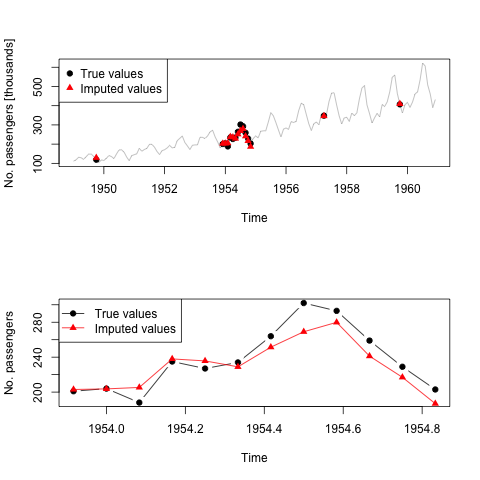

In [4]:
%%R -i series_ts

library(forecast)
library(ggplot2)

nulls_idx <- c(10, 60:71, 100, 130)
filled <- series_ts
filled[nulls_idx] = NA

fit <- auto.arima(filled)
kr <- KalmanRun(filled, fit$model)

filled[nulls_idx] <- sapply(
    nulls_idx, 
    FUN = function(t, Z, alpha) Z %*% alpha[t, ], 
    Z = fit$model$Z, 
    alpha = kr$states
)

# 2 subplots
par(mfrow = c(2, 1))

# Complete Time-Series
plot(series_ts, col = "gray", ylab = "No. passengers [thousands]")
points(
    time(series_ts)[nulls_idx],
    series_ts[nulls_idx], 
    col = "black",
    pch = 19
)
points(
    time(filled)[nulls_idx],
    filled[nulls_idx],
    col = "red", 
    pch = 17
)
ylab("No. passengers")
legend(
    "topleft", 
    legend = c("True values", "Imputed values"), 
    col = c("black", "red"), 
    pch = c(19, 17)
)

# Points 60:71
plot(
    time(series_ts)[60:71],
    series_ts[60:71],
    type = "b",
    col = "black", 
    pch = 19, 
    ylim = range(series_ts[60:71]),
    ylab = "No. passengers",
    xlab = "Time"
)
points(
    time(filled)[60:71], 
    filled[60:71], 
    col = "red", 
    pch = 17
)
lines(time(filled)[60:71], filled[60:71], col = "red")
legend(
    "topleft",
    legend = c("True values", "Imputed values"), 
    col = c("black", "red"), 
    pch = c(19, 17), 
    lty = c(1, 1)
)